# Get DEM from a bounding box

CoNED DEMs 

- North: https://chs.coast.noaa.gov/htdata/raster5/elevation/CA_north_coned_DEM_2020_9181/

- Central: https://chs.coast.noaa.gov/htdata/raster2/elevation/CA_Central_CoNED_DEM_2017_8657/

- Southern California: https://chs.coast.noaa.gov/htdata/raster2/elevation/CA_Southern_CoNED_DEM_2016_8658/

USGS El Nino dataset from 2016
- https://chs.coast.noaa.gov/htdata/raster2/elevation/West_Coast_El_Nino_DEM_2016_6260/

Most of the script uses data that has been downloaded, but you can also hit the URL for a DEM directly (example below) and/or try and download the VRT files and loop through them to check the bounds and find the DEM of interest

In [4]:
# from BZ import *
import xarray as xr
import rioxarray as xrr
from rioxarray.merge import merge_arrays
import geopandas as gpd
from shapely.geometry import box

import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
import seaborn as sns

## i had lots if extra imoprts in here; you may need to download additional packages
# from shared import * 

%matplotlib inline
%pdb off
    
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI' # this is where I had the DEMs stoerd at

Automatic pdb calling has been turned OFF
(SL)  2024-08-01 15:49:28.471137


In [2]:
## this is Cabrillo Beach plus a buffer
pt_lalo = 33.710835, -118.283111
gser_pt = gpd.GeoSeries(gpd.points_from_xy([pt_lalo[1]], [pt_lalo[0]]), crs=4326)
gser_bbox = gser_pt.buffer(0.01, cap_style=3)

/tmp/ipykernel_2851658/1389690490.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gser_bbox = gser_pt.buffer(0.01, cap_style=3)


In [3]:
## just for plotting
basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

# CoNED

In [4]:
## this isnt actually needed
# path_dems = path_wd / 'dems'
# path_dems_all  = path_dems / 'all' # symlinked with everything

# path_north   = path_dems / 'CA_north_coned_DEM_2020_9181'
# gdf_north    = gpd.read_file(path_north / 'tileindex_CA_north_coned_DEM_2020.shp').to_crs(4326)

# path_central = path_dems / 'CA_Central_CoNED_DEM_2017_8657'
# gdf_central  = gpd.read_file(path_central / 'ca2017_central_coned_m8657.kmz').to_crs(4326)

# path_south   = path_dems / 'CA_Southern_CoNED_DEM_2016_8658/'
# gdf_south    = gpd.read_file(path_south / 'socal.kmz').to_crs(4326)

# dct_gdf_bounds = {'South': gdf_south, 'Central': gdf_central, 'North': gdf_north}

# from shapely.geometry import box
# found = False
# for reg, geom in dct_gdf_bounds.items():
#     gdf_reg = gpd.GeoSeries(box(*geom.total_bounds), crs=4326)
#     if gdf_reg.contains(gser_bbox).item():
#         found = True
#         break
# if found:
#     print ('CoNED Region:', reg)
# else:
#     print ('Couldnt find region of DEMS')

In [7]:
## this is if oyu have the dems all downloaded to path_dems_all; otherwise see below cell
# get the paths to the dems that overlap with the desired box
lst_dems = []
for i, path_dem in enumerate(path_dems_all.glob(f'*.tif')):
    da_dem = xrr.open_rasterio(path_dem).sel(band=1)
    gser_bounds = gpd.GeoSeries(box(*da_dem.rio.bounds()), crs=da_dem.rio.crs).to_crs(4326)
    if gser_bounds.intersects(gser_bbox).item():
        print (path_dem)
        da_dem_wgs = da_dem.rio.reproject(4326)
        da_dem_bbox = da_dem_wgs.rio.clip(gser_bbox.geometry, da_dem_wgs.rio.crs, all_touched=True)
        lst_dems.append(da_dem_bbox)

/scratch/tws_grace/data/Sea_Level/SFEI/dems/all/Southern_California_Topobathy_DEM_1m_E_10.tif


In [ ]:
## you can copy the file names in like this and then open them directly with rasterio
files = ['Northern_California_CoNED_TBDEM_1m_040_008.tif']
for i in files:
    da = xrr.open_rasterio(f'https://chs.coast.noaa.gov/htdata/raster5/elevation/CA_north_coned_DEM_2020_9181/{f}')

In [17]:
# merge the tiles
da_dem_wgs = merge_arrays(lst_dems)
da_dem_wgs = da_dem_wgs.where(da_dem_wgs>-3e4).rename(x='lon', y='lat')
da_dem_wgs.rio.write_nodata(da_dem_wgs.rio.nodata, encoded=True, inplace=True)
da_dem_wgs.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
da_dem_wgs.rio.write_crs("EPSG:4326", inplace=True);

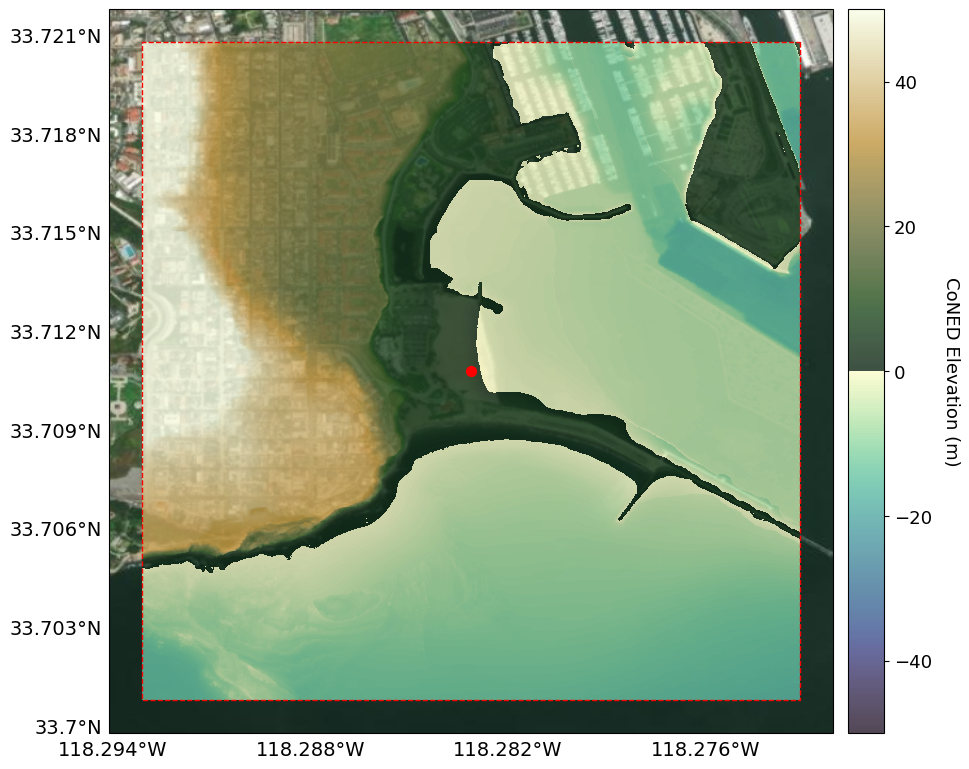

In [22]:
from BZ import bbPlot
sty_bbox = dict(facecolor='none', edgecolor='red', linestyle='--')
sty = dict(shading='nearest', transform=projp, cmap='cmo.topo', norm=mpl.colors.Normalize(-50, 50), alpha=0.8)

fig, axes = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projp})
    # ax.set_extent([wd-buff,ed+buff,sd-buff,nd+buff], crs=ccrs.UTM(10))
    # cx.add_basemap(ax=ax, crs=da_dem2.rio.crs, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)
gser_bbox.plot(ax=axes, **sty_bbox, zorder=10)
cx.add_basemap(ax=axes, crs=da_dem_wgs.rio.crs, source=cxbasemap, attribution=False)

im = axes.pcolormesh(da_dem_wgs.lon, da_dem_wgs.lat, da_dem_wgs, **sty) 
axes.scatter(pt_lalo[1], pt_lalo[0], transform=projp, color='r', s=50)
bbPlot.cartopy_cbar(im, ylabel=f'CoNED Elevation (m)')
gl = axes.gridlines(draw_labels=True)
bbPlot.fmt_gridlines(gl, bottom=True, size=GS);


In [23]:
# Save the DataArray to a GeoTIFF file
dst = path_dems_all / "Cabrillo_Beach_CoNED.tif"
da_dem_wgs.rio.to_raster(dst)
print (f'Wrote: {dst}')

Wrote: /scratch/tws_grace/data/Sea_Level/SFEI/dems/all/Cabrillo_Beach_CoNED.tif


# El Nino
- You'll have to develop a script for the El Nino dataset based on what's above. I had some other functinos developed that relied on reading files to map bounds and projections correctly.

In [25]:
# from make_slr_cari import get_enso_poly

In [61]:
path_enso_dems = path_dems / 'West_Coast_El_Nino'
gdf_enso_map = get_enso_map(path_enso_dems, 4326)

INFO:   get_enso_map:194    [Jul 24, 15:07:35] Wrote enso to dem map for EPSG: 4326


In [85]:
gdf_enso_map_poly = gdf_enso_map[gdf_enso_map.intersects(gser_bbox.geometry.item())]
if gdf_enso_map_poly.empty:
    print ('No ENSO tiles overlapped bbox')

else:
    # not texted below here
    lst_da_enso = []
    for path in gdf_enso_map_poly['path']:
        da_enso_dem1 = xrr.open_rasterio(path)
        lst_da_enso.append(da_enso_dem1)
    
da_enso_dem = merge_arrays(lst_da_enso).squeeze() if len(lst_da_enso) > 1 else lst_da_enso[0]
da_enso_dem = da_enso_dem.rio.reproject(4326)

In [86]:
da_enso_dem = da_enso_dem.where(da_enso_dem>-3e4).rename(x='lon', y='lat')
da_enso_dem.rio.write_nodata(da_enso_dem.rio.nodata, encoded=True, inplace=True)
da_enso_dem.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
da_enso_dem.rio.write_crs("EPSG:4326", inplace=True);

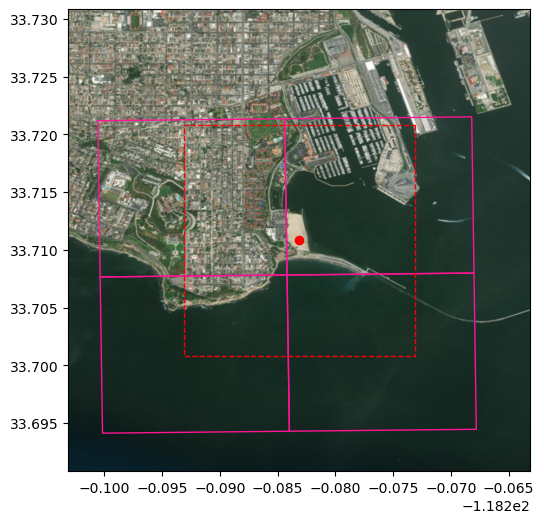

In [75]:
# outlines of enso dem tiles
buff = 0.01
w, s, e, n = gser_bbox.total_bounds
fig, axes = plt.subplots(figsize=(6,6))
axes.set_ylim([s-buff, n+buff])
axes.set_xlim([w-buff, e+buff])
gser_bbox.plot(ax=axes, **sty_bbox, zorder=10)
gser_pt.plot(ax=axes, color='r')
gdf_enso_map_poly.plot(ax=axes, facecolor='none', edgecolor='deeppink')
cx.add_basemap(ax=axes, crs=gser_bbox.crs, source=cxbasemap, attribution=False)

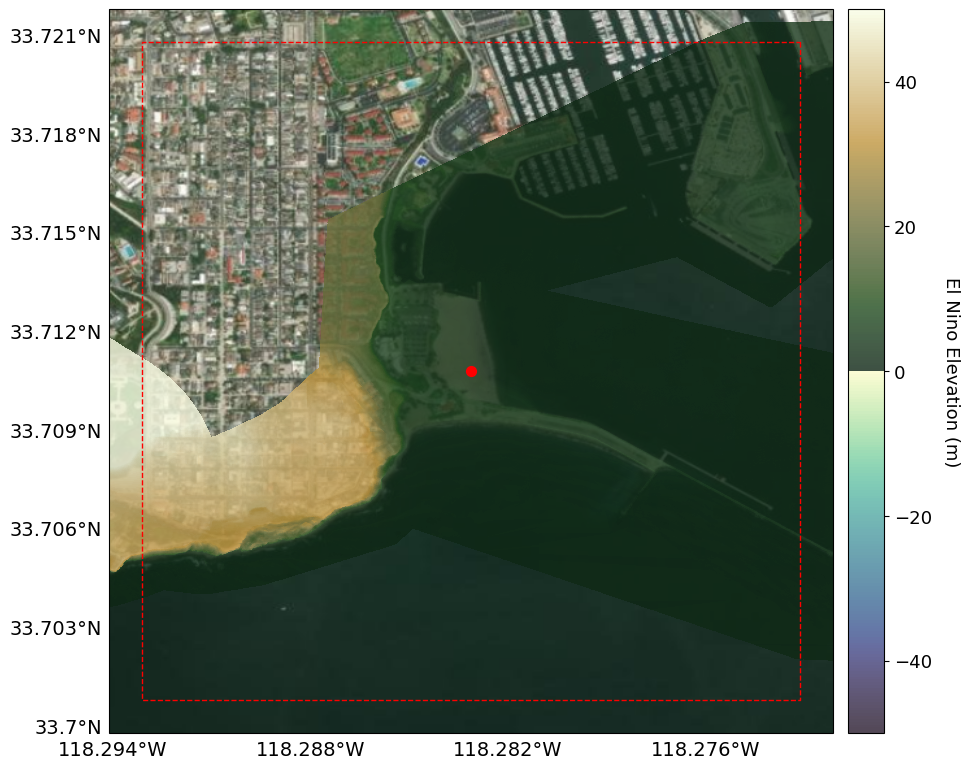

In [88]:
sty_bbox = dict(facecolor='none', edgecolor='red', linestyle='--')
sty = dict(shading='nearest', transform=projp, cmap='cmo.topo', norm=mpl.colors.Normalize(-50, 50), alpha=0.8)

fig, axes = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projp})
    # ax.set_extent([wd-buff,ed+buff,sd-buff,nd+buff], crs=ccrs.UTM(10))
    # cx.add_basemap(ax=ax, crs=da_dem2.rio.crs, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)
gser_bbox.plot(ax=axes, **sty_bbox, zorder=10)
cx.add_basemap(ax=axes, crs=da_enso_dem.rio.crs, source=cxbasemap, attribution=False)

im = axes.pcolormesh(da_enso_dem.lon, da_enso_dem.lat, da_enso_dem, **sty) 
axes.scatter(pt_lalo[1], pt_lalo[0], transform=projp, color='r', s=50)
bbPlot.cartopy_cbar(im, ylabel=f'El Nino Elevation (m)')
gl = axes.gridlines(draw_labels=True)
bbPlot.fmt_gridlines(gl, bottom=True, size=GS);

In [91]:
# Save the DataArray to a GeoTIFF file
dst = path_dems_all / "Cabrillo_Beach_elnino.tif"
da_enso_dem.rio.to_raster(dst)
print (f'Wrote: {dst}')

Wrote: /scratch/tws_grace/data/Sea_Level/SFEI/dems/all/Cabrillo_Beach_elnino.tif


# CoNED - El Nino

In [78]:
da_coned_dem = da_dem_wgs

In [92]:
da_coned_dem_enso = da_coned_dem.interp_like(da_enso_dem) - da_enso_dem

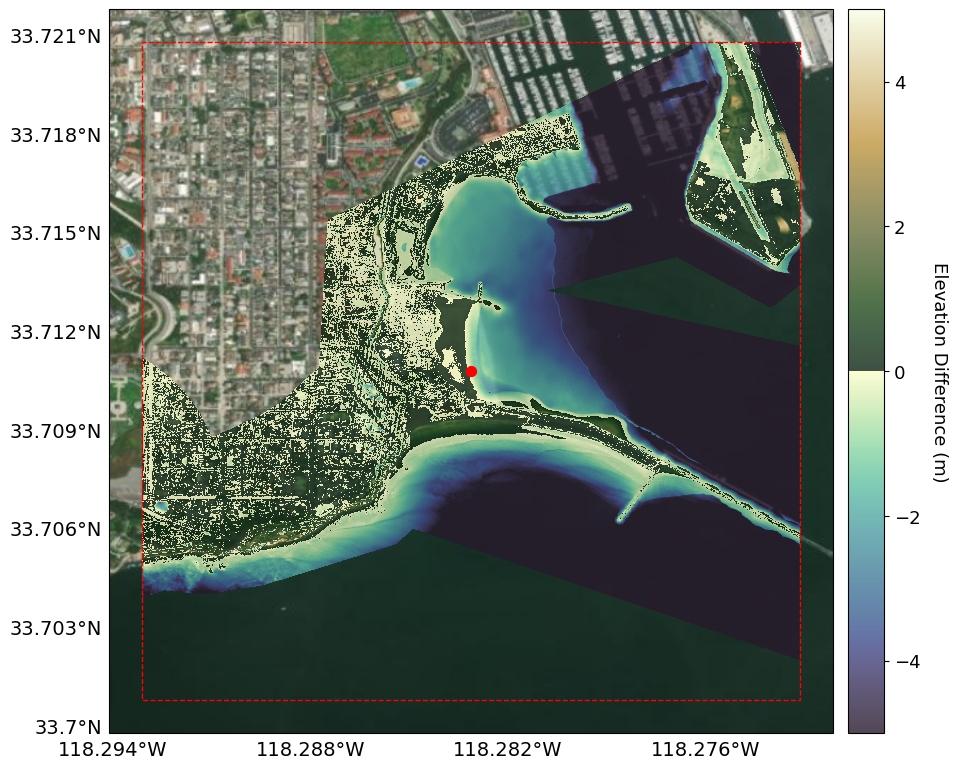

In [93]:
sty_bbox = dict(facecolor='none', edgecolor='red', linestyle='--')
sty = dict(shading='nearest', transform=projp, cmap='cmo.topo', norm=mpl.colors.Normalize(-5, 5), alpha=0.8)

fig, axes = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projp})
gser_bbox.plot(ax=axes, **sty_bbox, zorder=10)
cx.add_basemap(ax=axes, crs=da_coned_dem_enso.rio.crs, source=cxbasemap, attribution=False)

im = axes.pcolormesh(da_coned_dem_enso.lon, da_coned_dem_enso.lat, da_coned_dem_enso, **sty) 
axes.scatter(pt_lalo[1], pt_lalo[0], transform=projp, color='r', s=50)
bbPlot.cartopy_cbar(im, ylabel=f'Elevation Difference (m)')
gl = axes.gridlines(draw_labels=True)
bbPlot.fmt_gridlines(gl, bottom=True, size=GS);